# ATM Interface Project Report


## 1. Introduction
This report presents the development and implementation of an advanced ATM (Automated Teller Machine) interface using Python. The project was undertaken as part of a Python Programming internship, with the goal of creating a fully functional ATM interface.

### 1.1 Project Objectives

* Develop a functional ATM interface using Python
* Implement core banking operations (balance inquiry, withdrawal, deposit, transfer)
* Enhance the basic functionality with advanced features
* Demonstrate proficiency in Python programming and software development concepts

### 1.2 Technologies Used

* Python 3.x
* SQLite for database management
* Matplotlib for data visualization
* Jupyter Notebook for development and presentation

## 2. System Design

### 2.1 Architecture Overview
The ATM interface is designed with a modular architecture, separating core functionalities into distinct functions. The system uses a SQLite database for persistent storage of account information and transactions.

### 2.2 Database Schema

Two main tables are used in the database:

#### 1.accounts table:

* account_number (Primary Key)
* pin_hash
* balance
* name
  
#### 2.transactions table:

* id (Primary Key)
* account_number
* type
* amount
* timestamp
* category

### 2.3 Security Considerations

* PINs are hashed using SHA-256 before storage
* Sensitive input (PINs) uses the getpass module to mask input

In [22]:
import sqlite3
import hashlib
import os
from datetime import datetime
import matplotlib.pyplot as plt
from getpass import getpass
import numpy as np

In [2]:
conn = sqlite3.connect('atm.db')
cursor = conn.cursor()

In [3]:
# Create tables if they don't exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS accounts (
    account_number TEXT PRIMARY KEY,
    pin_hash TEXT,
    balance REAL,
    name TEXT
)
''')

In [4]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS transactions (
    id INTEGER PRIMARY KEY,
    account_number TEXT,
    type TEXT,
    amount REAL,
    timestamp DATETIME,
    category TEXT
)
''')

In [5]:
conn.commit()

In [6]:
# Helper function for hashing PINs
def hash_pin(pin):
    return hashlib.sha256(pin.encode()).hexdigest()


In [18]:
# Initialize some accounts if the database is empty
cursor.execute("SELECT COUNT(*) FROM accounts")
if cursor.fetchone()[0] == 0:
    initial_accounts = [
        ('12345', '1234', 1000, 'Alice'),
        ('67890', '5678', 2000, 'Bob')
    ]
    for account in initial_accounts:
        cursor.execute("INSERT INTO accounts VALUES (?, ?, ?, ?)",
                       (account[0], hash_pin(account[1]), account[2], account[3]))
    conn.commit()

 ATM functions.

In [8]:
def check_balance(account):
    cursor.execute("SELECT balance FROM accounts WHERE account_number = ?", (account,))
    balance = cursor.fetchone()[0]
    print(f"Your current balance is ${balance:.2f}")

In [9]:
def withdraw(account):
    amount = float(input("Enter the amount to withdraw: $"))
    cursor.execute("SELECT balance FROM accounts WHERE account_number = ?", (account,))
    balance = cursor.fetchone()[0]
    if amount > balance:
        print("Insufficient funds!")
    elif amount <= 0:
        print("Invalid amount!")
    else:
        new_balance = balance - amount
        cursor.execute("UPDATE accounts SET balance = ? WHERE account_number = ?", (new_balance, account))
        log_transaction(account, "withdrawal", -amount)
        conn.commit()
        print(f"Withdrawn ${amount:.2f}. New balance: ${new_balance:.2f}")


In [10]:
def deposit(account):
    amount = float(input("Enter the amount to deposit: $"))
    if amount <= 0:
        print("Invalid amount!")
    else:
        cursor.execute("SELECT balance FROM accounts WHERE account_number = ?", (account,))
        balance = cursor.fetchone()[0]
        new_balance = balance + amount
        cursor.execute("UPDATE accounts SET balance = ? WHERE account_number = ?", (new_balance, account))
        log_transaction(account, "deposit", amount)
        conn.commit()
        print(f"Deposited ${amount:.2f}. New balance: ${new_balance:.2f}")

In [11]:
def transfer(account):
    target = input("Enter the account number to transfer to: ")
    cursor.execute("SELECT account_number FROM accounts WHERE account_number = ?", (target,))
    if cursor.fetchone() is None:
        print("Target account does not exist!")
        return
    amount = float(input("Enter the amount to transfer: $"))
    cursor.execute("SELECT balance FROM accounts WHERE account_number = ?", (account,))
    balance = cursor.fetchone()[0]
    if amount > balance:
        print("Insufficient funds!")
    elif amount <= 0:
        print("Invalid amount!")
    else:
        new_balance = balance - amount
        cursor.execute("UPDATE accounts SET balance = ? WHERE account_number = ?", (new_balance, account))
        cursor.execute("UPDATE accounts SET balance = balance + ? WHERE account_number = ?", (amount, target))
        log_transaction(account, "transfer out", -amount)
        log_transaction(target, "transfer in", amount)
        conn.commit()
        print(f"Transferred ${amount:.2f} to account {target}.")
        print(f"New balance: ${new_balance:.2f}")

In [12]:
def log_transaction(account, transaction_type, amount):
    category = input("Enter transaction category (e.g., food, entertainment, bills): ")
    cursor.execute("""
    INSERT INTO transactions (account_number, type, amount, timestamp, category)
    VALUES (?, ?, ?, ?, ?)
    """, (account, transaction_type, amount, datetime.now(), category))

In [13]:
def view_transactions(account):
    cursor.execute("""
    SELECT type, amount, timestamp, category
    FROM transactions
    WHERE account_number = ?
    ORDER BY timestamp DESC
    LIMIT 10
    """, (account,))
    transactions = cursor.fetchall()
    if not transactions:
        print("No transactions found.")
    else:
        print("\nRecent Transactions:")
        for transaction in transactions:
            print(f"{transaction[2]} - {transaction[0]}: ${transaction[1]:.2f} (Category: {transaction[3]})")


In [20]:
def visualize_spending(account):
    # Print all transactions for debugging
    cursor.execute("SELECT * FROM transactions WHERE account_number = ?", (account,))
    all_transactions = cursor.fetchall()
    print("All transactions:", all_transactions)  # Debugging output

    # Fetch spending data (withdrawals and transfers out only) and normalize categories to lowercase
    cursor.execute("""
    SELECT LOWER(category), SUM(amount)
    FROM transactions
    WHERE account_number = ? AND type IN ('withdrawal', 'transfer out')
    GROUP BY LOWER(category)
    """, (account,))
    spending = cursor.fetchall()

    # Check if there's any spending data
    if not spending:
        print("No valid spending data to plot.")
        return

    # Unpack categories and amounts
    categories, amounts = zip(*spending)

    # Handle negative amounts since spending is negative (convert to positive for plotting)
    amounts = np.abs(amounts)

    # Check for non-zero amounts
    if np.sum(amounts) == 0:
        print("No valid spending data to plot.")
        return

    # Plot pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(amounts, labels=categories, autopct='%1.1f%%')
    plt.title("Spending by Category")
    plt.axis('equal')
    plt.show()


In [15]:
def change_pin(account):
    current_pin = getpass("Enter your current PIN: ")
    cursor.execute("SELECT pin_hash FROM accounts WHERE account_number = ?", (account,))
    stored_hash = cursor.fetchone()[0]
    if hash_pin(current_pin) != stored_hash:
        print("Incorrect PIN!")
        return
    new_pin = getpass("Enter your new PIN: ")
    confirm_pin = getpass("Confirm your new PIN: ")
    if new_pin != confirm_pin:
        print("PINs do not match!")
        return
    new_hash = hash_pin(new_pin)
    cursor.execute("UPDATE accounts SET pin_hash = ? WHERE account_number = ?", (new_hash, account))
    conn.commit()
    print("PIN changed successfully.")

 main ATM interface.

In [16]:
def atm_interface():
    while True:
        account = input("Enter your account number (or 'q' to quit): ")
        if account.lower() == 'q':
            print("Thank you for using our ATM. Goodbye!")
            break
        
        cursor.execute("SELECT pin_hash, name FROM accounts WHERE account_number = ?", (account,))
        result = cursor.fetchone()
        if result is None:
            print("Account not found!")
            continue
        
        stored_hash, name = result
        pin = getpass("Enter your PIN: ")
        if hash_pin(pin) != stored_hash:
            print("Incorrect PIN!")
            continue
        
        print(f"\nWelcome, {name}!")
        
        while True:
            print("\n1. Check Balance")
            print("2. Withdraw")
            print("3. Deposit")
            print("4. Transfer")
            print("5. View Recent Transactions")
            print("6. Visualize Spending")
            print("7. Change PIN")
            print("8. Logout")
            
            choice = input("Enter your choice: ")
            
            if choice == '1':
                check_balance(account)
            elif choice == '2':
                withdraw(account)
            elif choice == '3':
                deposit(account)
            elif choice == '4':
                transfer(account)
            elif choice == '5':
                view_transactions(account)
            elif choice == '6':
                visualize_spending(account)
            elif choice == '7':
                change_pin(account)
            elif choice == '8':
                print("Logged out successfully.")
                break
            else:
                print("Invalid choice. Please try again.")

Enter your account number (or 'q' to quit):  67890
Enter your PIN:  ········



Welcome, Bob!

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  1


Your current balance is $2500.00

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  2
Enter the amount to withdraw: $ 300
Enter transaction category (e.g., food, entertainment, bills):  bills


Withdrawn $300.00. New balance: $2200.00

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  3
Enter the amount to deposit: $ 500
Enter transaction category (e.g., food, entertainment, bills):  entertainment


Deposited $500.00. New balance: $2700.00

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  4
Enter the account number to transfer to:  12345
Enter the amount to transfer: $ 350
Enter transaction category (e.g., food, entertainment, bills):  bills
Enter transaction category (e.g., food, entertainment, bills):  bills


Transferred $350.00 to account 12345.
New balance: $2350.00

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  5



Recent Transactions:
2024-09-20 17:12:05.624966 - transfer out: $-350.00 (Category: bills)
2024-09-20 17:11:38.319306 - deposit: $500.00 (Category: entertainment)
2024-09-20 17:11:23.442713 - withdrawal: $-300.00 (Category: bills)
2024-09-20 17:07:51.773525 - transfer out: $-1000.00 (Category: food)
2024-09-20 17:07:05.051797 - deposit: $500.00 (Category: bills)
2024-09-20 17:06:48.059971 - withdrawal: $-200.00 (Category: food)
2024-09-20 15:24:19.121045 - transfer in: $500.00 (Category: bills)
2024-09-20 15:16:11.405793 - transfer in: $200.00 (Category: food)
2024-09-20 14:32:27.027685 - transfer in: $500.00 (Category: bills)

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  6


All transactions: [(2, '67890', 'transfer in', 500.0, '2024-09-20 14:32:27.027685', 'bills'), (6, '67890', 'transfer in', 200.0, '2024-09-20 15:16:11.405793', 'food'), (9, '67890', 'transfer in', 500.0, '2024-09-20 15:24:19.121045', 'bills'), (11, '67890', 'withdrawal', -200.0, '2024-09-20 17:06:48.059971', 'food'), (12, '67890', 'deposit', 500.0, '2024-09-20 17:07:05.051797', 'bills'), (13, '67890', 'transfer out', -1000.0, '2024-09-20 17:07:51.773525', 'food'), (15, '67890', 'withdrawal', -300.0, '2024-09-20 17:11:23.442713', 'bills'), (16, '67890', 'deposit', 500.0, '2024-09-20 17:11:38.319306', 'entertainment'), (17, '67890', 'transfer out', -350.0, '2024-09-20 17:12:05.624966', 'bills')]


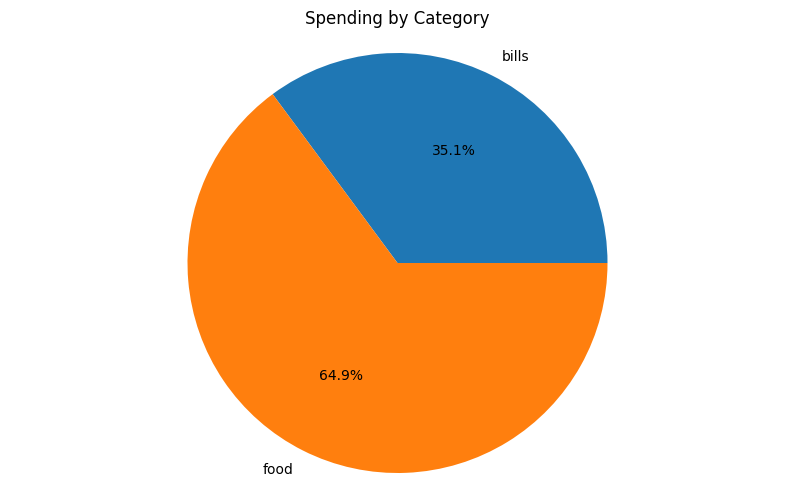


1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  7
Enter your current PIN:  ········


Incorrect PIN!

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  7
Enter your current PIN:  ········
Enter your new PIN:  ········
Confirm your new PIN:  ········


PIN changed successfully.

1. Check Balance
2. Withdraw
3. Deposit
4. Transfer
5. View Recent Transactions
6. Visualize Spending
7. Change PIN
8. Logout


Enter your choice:  8


Logged out successfully.


Enter your account number (or 'q' to quit):  q


Thank you for using our ATM. Goodbye!


In [25]:
# Run the ATM interface
atm_interface()

## 3. Implementation Details

## 3.1 Core Functions

* check_balance(account): Retrieves and displays the current balance
* withdraw(account): Handles cash withdrawal
* deposit(account): Processes cash deposits
* transfer(account): Manages fund transfers between accounts
* log_transaction(account, transaction_type, amount): Records all transactions
* view_transactions(account): Displays recent transactions
* visualize_spending(account): Generates a pie chart of spending by category
* change_pin(account): Allows users to change their PIN

### 3.2 Main Interface

The atm_interface() function serves as the main program loop, handling user authentication and menu navigation.

### 3.3 Data Visualization

The spending visualization feature uses Matplotlib to create a pie chart, offering users a graphical representation of their spending patterns.

## 4. Advanced Features
### 4.1 Database Integration
Unlike basic implementations that use in-memory data structures, this project uses SQLite for persistent storage. This allows for data retention between sessions and demonstrates database management skills.
### 4.2 Transaction Categorization
Users can categorize each transaction, enabling more detailed financial tracking and analysis.
### 4.3 Spending Visualization
The system can generate a pie chart of user spending by category, providing valuable insights into spending habits.
### 4.4 Enhanced Security
PINs are securely hashed before storage, and users can change their PINs. This demonstrates an understanding of basic security practices in financial systems.

## 5. Challenges and Solutions
### 5.1 Database Management
Challenge: Implementing a persistent storage solution.
Solution: Utilized SQLite, a lightweight database that doesn't require a separate server process.
### 5.2 Security Implementation
Challenge: Storing PINs securely.
Solution: Implemented PIN hashing using the SHA-256 algorithm.
### 5.3 Data Visualization
Challenge: Providing user-friendly insights into spending habits.
Solution: Integrated Matplotlib to create visual representations of transaction data.
## 6. Future Enhancements
Several potential improvements have been identified for future development:

* Graphical User Interface (GUI): Implement a user-friendly GUI using libraries like Tkinter or PyQt.
* Multi-Currency Support: Add functionality to handle multiple currencies and perform conversions.
* Scheduled Transactions: Implement features for setting up recurring payments or transfers.
* Account Types: Introduce different types of accounts (e.g., savings, checking) with varying interest rates.
* Web Interface: Develop a web-based version of the ATM interface using frameworks like Flask or Django.

## 7. Conclusion
This project successfully delivered a fully functional ATM interface with several advanced features, meeting and exceeding the initial project requirements. The implementation demonstrates proficiency in Python programming, database management, security considerations, and data visualization.
The modular design of the system allows for easy maintenance and future enhancements. The inclusion of advanced features like spending visualization and transaction categorization adds significant value to the basic ATM functionality.
This project has provided valuable experience in software development practices, database integration, and creating user-centric financial applications.